In [81]:
import time
import base64
from io import BytesIO
from openai import OpenAI
import re
from PIL import Image, ImageDraw, ImageFont
import random
import json
import fitz  # PyMuPDF


client = OpenAI(
    api_key="taco",
    # base_url="http://localhost:8000/v1",
    base_url="https://llm.dsrs.illinois.edu/v1", # if exposed in port 8000
    timeout=3600
)

client.models.list().data[0].id

'deepseek-ai/DeepSeek-OCR'

In [70]:
# HELPER: Convert PIL Image to Base64 String
def encode_image_to_base64(pil_image):
    buffered = BytesIO()
    # Save as JPEG (or PNG) into the buffer
    pil_image.save(buffered, format="JPEG")
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

# HELPER: Draw bboxes YOLO style
def draw_deepseek_results(image: Image.Image, response_text: str, text=True) -> Image.Image:
    """
    Parses DeepSeek-OCR output and draws 'Pro' style bounding boxes.
    - Transparent fills.
    - Text attached to top-left.
    - Text has NO background box, but uses the same color as the bbox.
    """
    # 1. Canvas Setup
    vis_image = image.convert("RGBA")
    overlay = Image.new("RGBA", vis_image.size, (255, 255, 255, 0))
    draw_overlay = ImageDraw.Draw(overlay)
    draw_text = ImageDraw.Draw(vis_image) # Draw text on top layer for sharpness
    
    img_w, img_h = vis_image.size

    # 2. Font Loader (Try to look professional)
    try:
        # Standard path in many Linux/Docker envs
        font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 18)
    except OSError:
        try:
            # Fallback for Mac/Windows
            font = ImageFont.truetype("Arial.ttf", 18)
        except OSError:
            font = ImageFont.load_default()

    # 3. Professional Color Palette (Bright, Rotating)
    palette = [
        (255, 50, 50),   # Red
        (50, 255, 50),   # Lime Green
        (50, 100, 255),  # Azure Blue
        (255, 140, 0),   # Orange
        (200, 0, 200),   # Purple
        (0, 200, 200),   # Cyan
        (255, 215, 0)    # Gold
    ]

    # 4. Regex Parser for <|ref|>label<|/ref|><|det|>[[x1,y1,x2,y2]]<|/det|>
    pattern = r"<\|ref\|>(.*?)<\|/ref\|><\|det\|>\[\[\s*(\d+),\s*(\d+),\s*(\d+),\s*(\d+)\s*\]\]<\|/det\|>"
    matches = re.findall(pattern, response_text)

    for i, (label, x1, y1, x2, y2) in enumerate(matches):
        # Normalize coordinates (0-1000) -> Pixels
        box = [
            int(int(x1) / 1000 * img_w),
            int(int(y1) / 1000 * img_h),
            int(int(x2) / 1000 * img_w),
            int(int(y2) / 1000 * img_h)
        ]
        
        # Pick color
        color_rgb = palette[i % len(palette)]
        fill_color = color_rgb + (40,)   # 15% opacity
        outline_color = color_rgb + (255,) # 100% opacity

        # A. Draw Box (Fill + Outline)
        draw_overlay.rectangle(box, 
                               fill=fill_color, 
                               outline=outline_color, 
                               width=1)

        # B. Draw Text (No background box!)
        
        if text:
            
            # Calculate position (Top-Left, slightly above box)
            text_bbox = draw_text.textbbox((0, 0), label, font=font)
            text_h = text_bbox[3] - text_bbox[1]
            
            text_x = box[0] + 2
            text_y = box[1] - text_h - 4
            
            # If text goes off-screen top, move it inside the box
            if text_y < 0:
                text_y = box[1] + 4
    
            # Draw Text with Stroke (The "Pro" Trick)
            # stroke_width=2 creates a tiny white border so you can read the text 
            # against any background, eliminating the need for a text box.
            
            
            draw_text.text(
                (text_x, text_y), 
                label, 
                fill=outline_color, 
                font=font,
                stroke_width=1, 
                # stroke_fill=(255, 255, 255, 255) # White stroke
            )

    # 5. Composite
    out = Image.alpha_composite(vis_image, overlay)
    return out.convert("RGB")


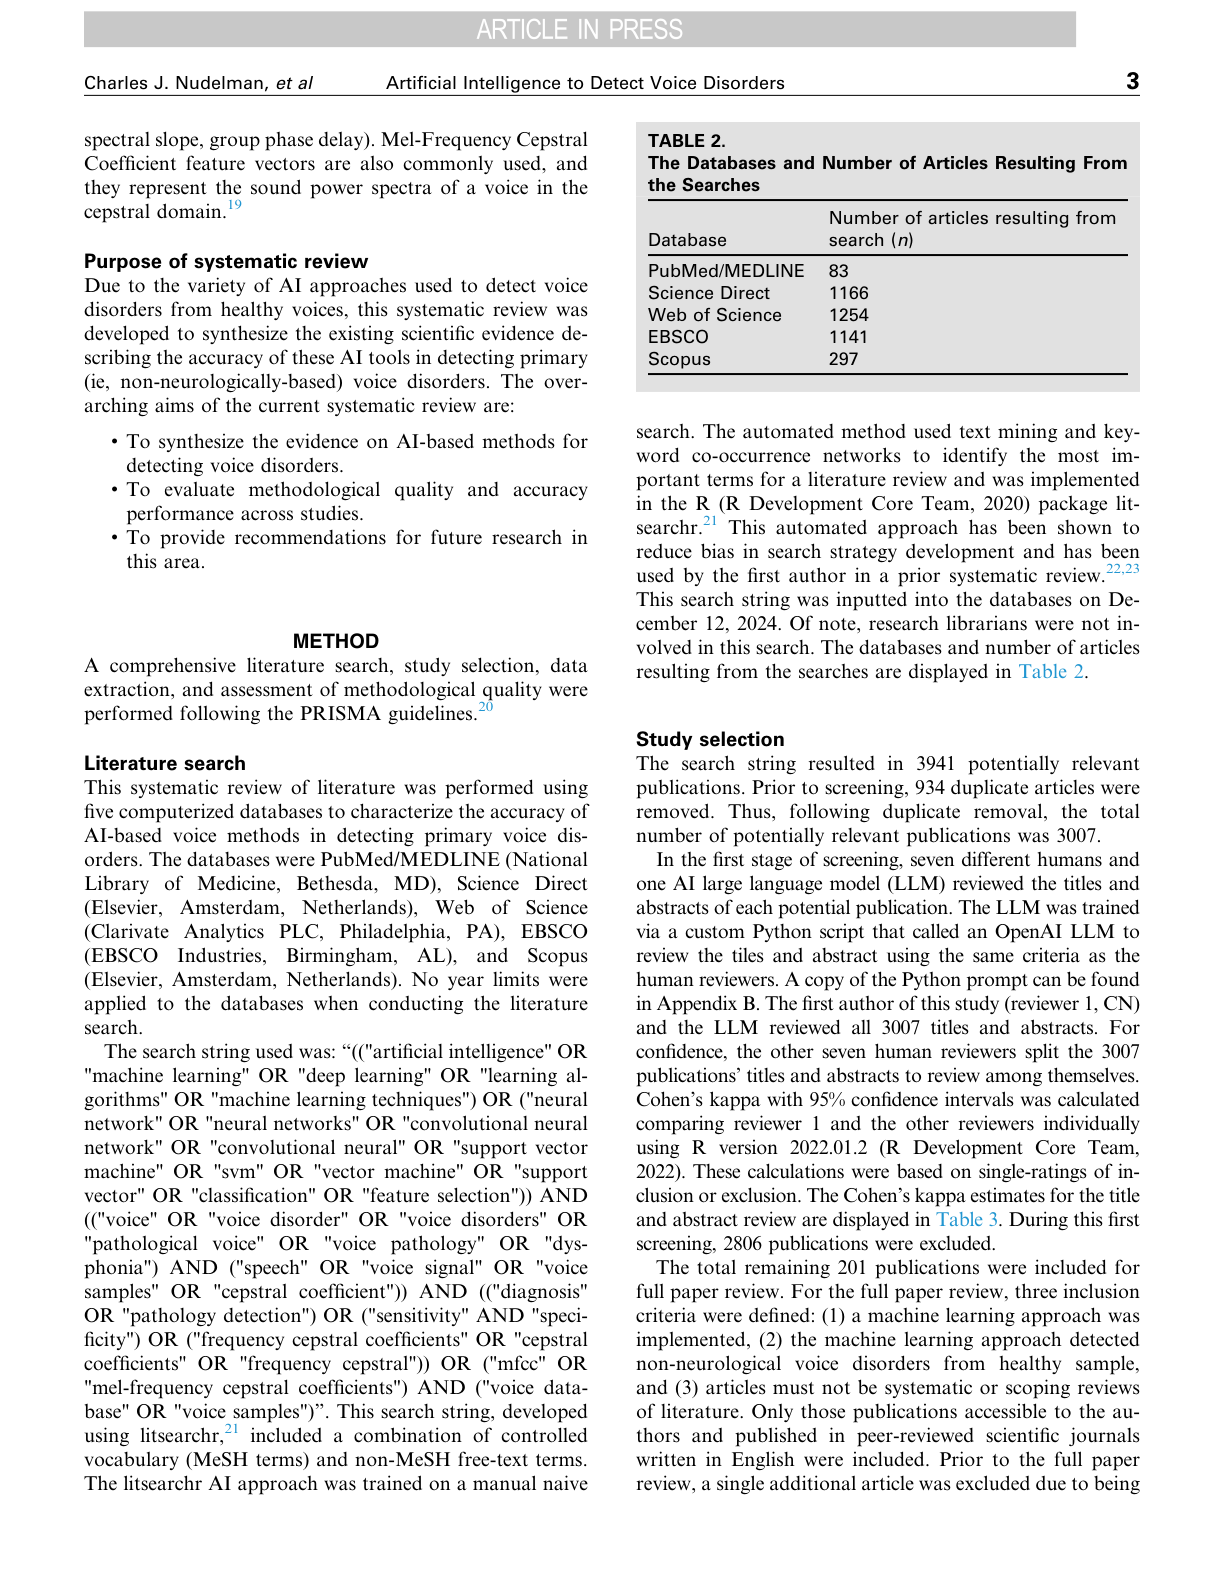

In [71]:
# ## Image

# pg = 10
# image_path = f"shared-dsrs/ai-notebooks/vllm-ocr-server/paper/Attention.pdf"
# image = Image.open(image_path)

# base64_image = encode_image_to_base64(image)



## PDF
pdf_path = "paper/Attention.pdf"
pdf_path = "paper/paki.pdf"
doc = fitz.open(pdf_path)

pg = 3
page = doc.load_page(pg-1)

# matrix=fitz.Matrix(2, 2) increases resolution (zoom x2) for better OCR
pix = page.get_pixmap(matrix=fitz.Matrix(2, 2)) 

# Create a PIL Image from the raw bytes
image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
base64_image = encode_image_to_base64(image)

image

In [75]:
## Prompt

# prompt = "<image>\nFree OCR."
#    document: <image>\n<|grounding|>Convert the document to markdown.
#    other image: <image>\n<|grounding|>OCR this image.
#    without layouts: <image>\nFree OCR.
#    figures in document: <image>\nParse the figure.
#    general: <image>\nDescribe this image in detail.
#    rec: <image>\nLocate <|ref|>xxxx<|/ref|> in the image.

# prompt = "<image>\n<|grounding|>Convert the document to markdown." # section/paragraph-wise
prompt = "<image>\n<|grounding|>OCR this image." # sentence-wise

In [76]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image_url",  # Standard OpenAI API expects 'image_url'
                "image_url": {
                    # Pass the base64 string as a Data URI
                    "url": f"data:image/jpeg;base64,{base64_image}"
                }
            },
            {
                "type": "text",
                "text": prompt
            }
        ]
    }
]

Sending request...
Response costs: 0.24s (Time to First Token)
Generated text: <|ref|>Charles J. Nudelman, et al<|/ref|><|det|>[[66, 44, 256, 59]]<|/det|>
<|ref|>Artificial Intelligence to Detect Voice Disorders<|/ref|><|det|>[[315, 44, 639, 58]]<|/det|>
<|ref|>3<|/ref|><|det|>[[916, 42, 930, 54]]<|/det|>
<|ref|>spectral slope, group phase delay). Mel-Frequency Cepstral<|/ref|><|det|>[[66, 80, 479, 98]]<|/det|>
<|ref|>TABLE2.<|/ref|><|det|>[[525, 80, 592, 94]]<|/det|>
<|ref|>Coefficient feature vectors are also commonly used, and<|/ref|><|det|>[[66, 95, 479, 112]]<|/det|>
<|ref|>The Databases and Number of Articles Resulting From<|/ref|><|det|>[[525, 95, 919, 110]]<|/det|>
<|ref|>they represent the sound power spectra of a voice in the<|/ref|><|det|>[[66, 110, 480, 128]]<|/det|>
<|ref|>the Searches<|/ref|><|det|>[[525, 110, 620, 124]]<|/det|>
<|ref|>cepstral domain.19<|/ref|><|det|>[[66, 125, 200, 142]]<|/det|>
<|ref|>Number of articles resulting from<|/ref|><|det|>[[671, 128, 916, 143

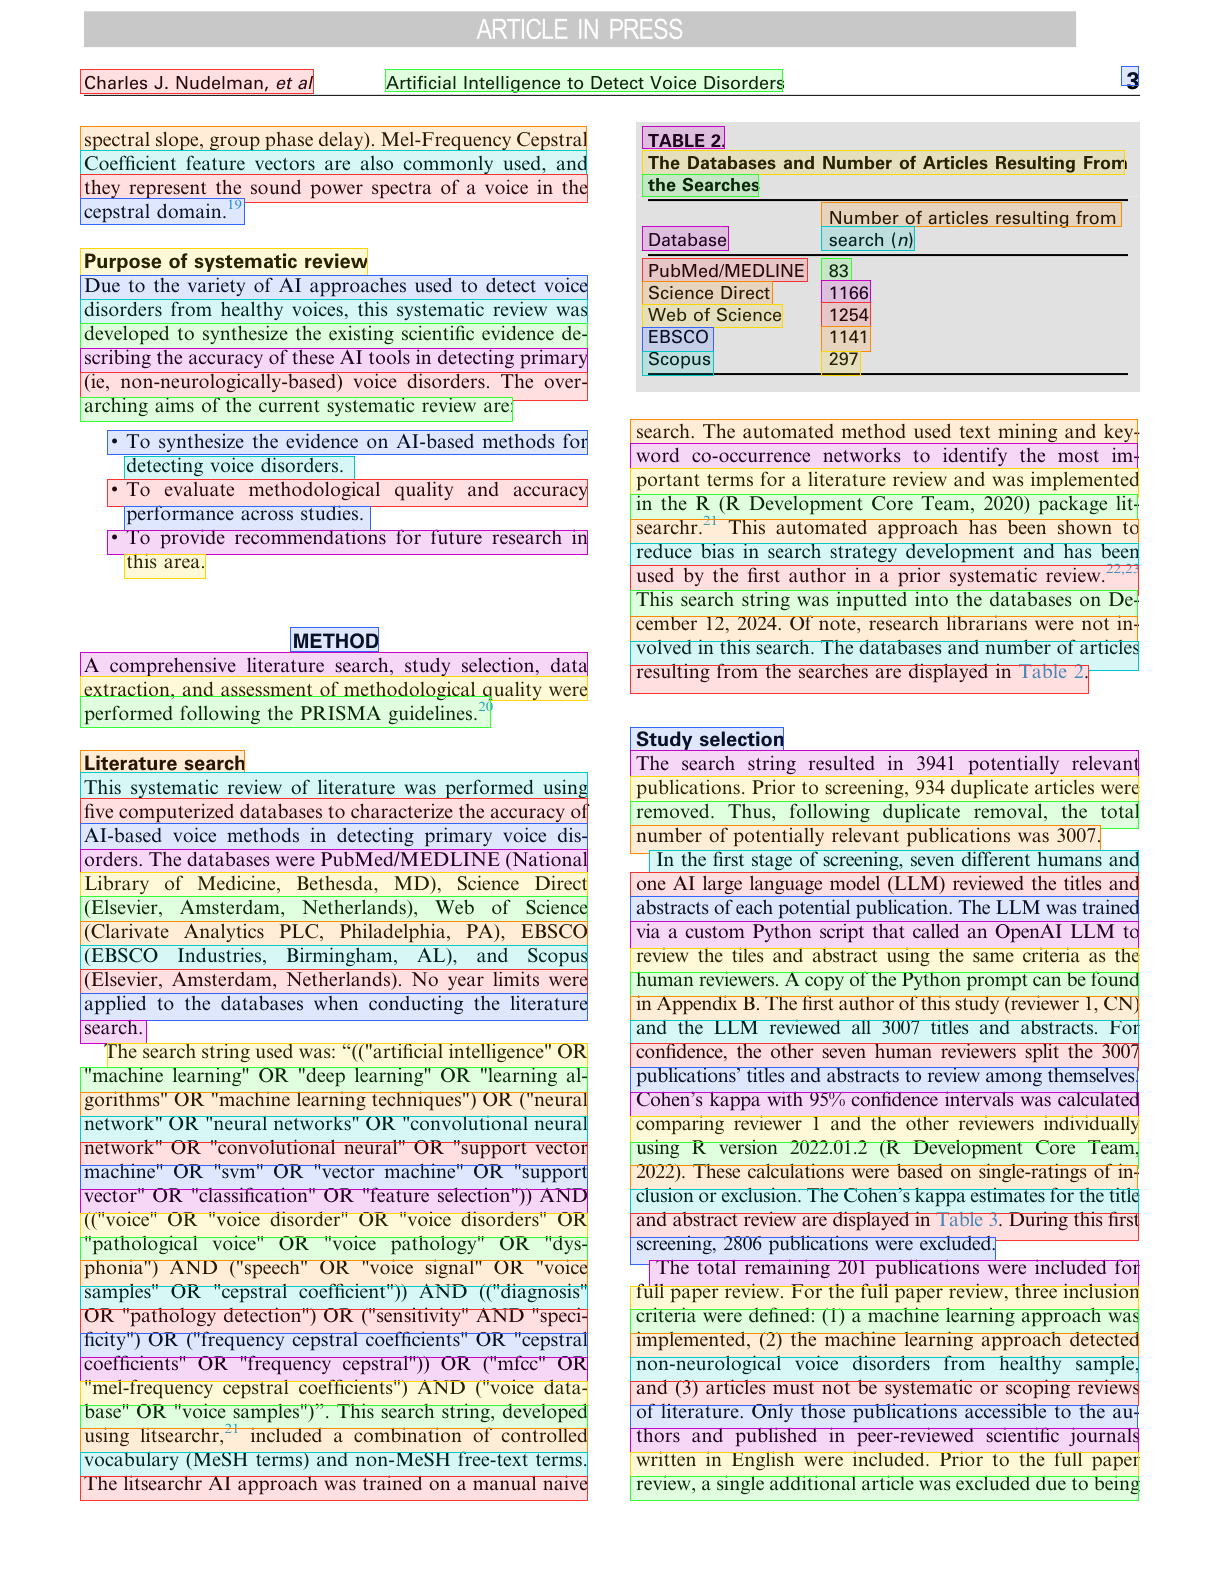

In [77]:
print("Sending request...")
start = time.time()

# 1. Enable Streaming
stream = client.chat.completions.create(
    model="deepseek-ai/DeepSeek-OCR",
    messages=messages,
    max_tokens=8_000,
    temperature=0,
    stream=True,  # <--- Set this to True
    extra_body={
        "skip_special_tokens": False,
        
        # A. LOGITS PROCESSOR (Your existing text controls)
        "vllm_xargs": {
            "ngram_size": 30,
            "window_size": 90,
            "whitelist_token_ids": [128821, 128822],
        },

        # B. IMAGE PROCESSOR (The "Gundam Mode" Config)
        # These overrides correspond to: base_size=1024, image_size=800, crop_mode=True
        "mm_processor_kwargs": {
            "crop_mode": True,          # Enable Tiling
            "base_image_size": 1280,    # Global Canvas size (Internal name is base_image_size)
            "image_size": 1280,         # Detail Tile size (User defined 800, Gundam default is 640)
        }
    },
)

print(f"Response costs: {time.time() - start:.2f}s (Time to First Token)")
print("Generated text: ", end="", flush=True)

# 2. Collect streamed content
full_text = ""
for chunk in stream:
    content = chunk.choices[0].delta.content
    if content:
        print(content, end="", flush=True)
        full_text += content

print("\n") # Newline after stream ends



## Image with bboxes!
if "<|det|>" in full_text:
    final_image = draw_deepseek_results(image, full_text, text=None)
    display(final_image)

# display(image, final_image)

## AI decides the most important text!

In [52]:
# HELPER: Get most important text o highlight using an LLM
def get_brain_highlights(model, raw_ocr_text, mode="technical"):
    """
    Extracts highlight strings using a System Prompt with embedded Few-Shot Examples.
    """
    
    # 1. Clean Input
    clean_text = re.sub(r"<\|det\|>.*?<\|/det\|>", "", raw_ocr_text)
    clean_text = clean_text.replace("<|ref|>", "").replace("<|/ref|>", "").strip()
    
    # 2. Personas!!
    personas = {
        "general": "Identify high-level strategic outcomes, major financial shifts (growth/decline), and core business conclusions.",
        "technical": "Literature review vs research paper. For literature review: look for the most robust findings related to the topic that are more often reported in the reviewed papers. For research papers: look for the research question, key information in the methods, key results, and implication of the results" #"Identify specific data points (%), precise dates, hardware specifications, and definitive causal claims."
    }
    goal_instruction = personas.get(mode, personas[mode])

    # 3. SYSTEM PROMPT; FEW-SHOT EXAMPLES
    system_prompt = f"""
    You are a Verbatim Text Extraction Engine. Your task is to extract exact substrings from a document based on a user's goal.

    <rules>
    1. VERBATIM ONLY: You must extract text EXACTLY as it appears. 
       - If the text says "profitt", you extract "profitt". 
       - Do not correct typos. Do not fix punctuation.
    2. JSON OUTPUT: Return a JSON object with a key "highlights".
    3. SCOPE: Extract short phrases (3-15 words). No full paragraphs.
    </rules>

    <examples>
    
    EXAMPLE 1 (Mode: Technical):

    <task_configuration>
    CURRENT MODE: "TECHNICAL"
    SPECIFIC GOAL: {personas["technical"]}
    </task_configuration>

    <document>
    "The server room temp reached 45C due to a fan failvre."
    </document>
    Output:
    {{
      "highlights": [
        {{ "reason": "Specific temperature data point. Explicitely appearing as: 'reached 45C' in sentence: 'The server room temp reached 45C due to a fan failvre.'", "text": "reached 45C" }},
        {{ "reason": "Specific hardware failure, preserving typo. Explicitely appearing as: 'fan failvre' in sentence: 'The server room temp reached 45C due to a fan failvre.'", "text": "fan failvre" }}
      ]
    }}


    EXAMPLE 2 (Mode: General):

    <task_configuration>
    CURRENT MODE: "GENERAL"
    SPECIFIC GOAL: {personas["general"]}
    </task_configuration>

    <document>
    "We are sad to say that revenve dropped by 10% this Q3."
    </document>
    
    Output:
    {{
      "highlights": [
        {{ "reason": "Key financial outcome (negative), explicitely appearing as: 'revenve dropped by 10% this Q3.' in sentence: 'We are sad to say that revenve dropped by 10% this Q3.'", "text": "revenve dropped by 10%" }}
      ]
    }}
    </examples>

    """

    # 4. USER PROMPT: Clean and simple
    user_prompt = f"""
    <task_configuration>
    CURRENT MODE: {mode.upper()}
    SPECIFIC GOAL: {goal_instruction}
    </task_configuration>

    <document>
    {clean_text}
    </document>
    """

    # 5. EXECUTE
    try:
        client = OpenAI(
            api_key="...",
        )
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            response_format={"type": "json_object"},
            temperature=0.0 # 0 is non-negotiable for verbatim tasks
        )
        
        data = json.loads(response.choices[0].message.content)
        return data #vs [item["text"] for item in data.get("highlights", [])]

    except Exception as e:
        print(f"Brain Error: {e}")
        return []



# HELPER: THE MATH ENGINE - Linear Interpolation to get bboxes for highlight
import re
from difflib import SequenceMatcher

def get_multiline_boxes(target_snippet, original_ocr_text, img_dims):
    """
    Heavy Duty Finder.
    1. Uses Python's difflib for 'Gestalt Pattern Matching' (handles missing chars/spaces).
    2. Lower threshold (0.6) to catch bad OCR.
    """
    img_w, img_h = img_dims
    
    # 1. Parse Data
    pattern = r"<\|ref\|>(.*?)<\|/ref\|><\|det\|>\[\[\s*(\d+),\s*(\d+),\s*(\d+),\s*(\d+)\s*\]\]<\|/det\|>"
    lines = re.findall(pattern, original_ocr_text)

    # 2. Build Spaceless Tape
    spaceless_doc_text = ""
    char_map = [] 

    for line_text, x1, y1, x2, y2 in lines:
        box = [int(x1), int(y1), int(x2), int(y2)]
        full_line_len = len(line_text)
        
        for char_i, char in enumerate(line_text):
            if not char.isspace():
                spaceless_doc_text += char.lower() 
                char_map.append({
                    "box": box,           
                    "char_idx": char_i,   
                    "line_len": full_line_len
                })

    # 3. Prepare Target
    clean_target = "".join(target_snippet.split()).lower()
    if not clean_target: return []

    # 4. FUZZY SEARCH (SequenceMatcher)
    # This is slower than simple == but much smarter about insertions/deletions
    
    start_idx = -1
    end_idx = -1
    best_ratio = 0.0
    
    target_len = len(clean_target)
    
    # Optimization: Only scan if we can't find exact match
    exact_loc = spaceless_doc_text.find(clean_target)
    
    if exact_loc != -1:
        start_idx = exact_loc
        end_idx = exact_loc + target_len
    else:
        # Sliding Window with SequenceMatcher
        # We scan the document. If the doc is huge, this can be slow, 
        # but for single pages it's fine (~0.5s).
        
        # We skip by 1 character. 
        for i in range(len(spaceless_doc_text) - target_len + 1):
            # Extract a window of the same length as target
            window = spaceless_doc_text[i : i + target_len]
            
            # Check similarity using Difflib (Handles shifted characters!)
            ratio = SequenceMatcher(None, window, clean_target).ratio()
            
            if ratio > best_ratio:
                best_ratio = ratio
                start_idx = i
        
        # LOWER THRESHOLD: 0.6 (60%) allows for significant OCR noise
        # while still being safe for phrases longer than 3-4 words.
        if best_ratio < 0.60:
            print(f"   (Failed: Best match for '{target_snippet}' was only {best_ratio:.2f})")
            return []
        
        end_idx = start_idx + target_len

    # 5. Calculate Boxes
    boxes_to_draw = []
    current_box_def = None
    segment_start_char = None
    segment_end_char = None
    current_line_len = 0

    for i in range(start_idx, end_idx):
        if i >= len(char_map): break
        info = char_map[i]
        
        if current_box_def != info["box"]:
            if current_box_def is not None:
                boxes_to_draw.append(
                    calculate_sub_box(current_box_def, segment_start_char, segment_end_char, img_dims, current_line_len)
                )
            current_box_def = info["box"]
            current_line_len = info["line_len"]
            segment_start_char = info["char_idx"]
        
        segment_end_char = info["char_idx"] + 1

    if current_box_def is not None:
        boxes_to_draw.append(
            calculate_sub_box(current_box_def, segment_start_char, segment_end_char, img_dims, current_line_len)
        )

    return boxes_to_draw

def calculate_sub_box(original_box, start_char, end_char, img_dims, line_len):
    img_w, img_h = img_dims
    lx1, ly1, lx2, ly2 = original_box
    box_width = lx2 - lx1
    px_per_char = box_width / line_len
    new_x1 = lx1 + (start_char * px_per_char)
    new_x2 = lx1 + (end_char * px_per_char)
    return [int(new_x1/1000*img_w), int(ly1/1000*img_h), int(new_x2/1000*img_w), int(ly2/1000*img_h)]

In [53]:
# # Scenario A: The General Reader
# highlights_general = get_brain_highlights("gpt-5.1",
#                                           full_text, 
#                                           "general") ## MODE

# print("\n--- GENERAL HIGHLIGHTS ---")
# print(highlights_general)

In [54]:
# Scenario B: The Technical/Expert
highlights_technical = get_brain_highlights("gpt-5.1",
                                            full_text, 
                                            "technical")  ## MODE

print("\n--- TECHNICAL HIGHLIGHTS ---")
print(highlights_technical)


--- TECHNICAL HIGHLIGHTS ---
{'highlights': [{'reason': 'States the main purpose of the systematic review (research question/aim).', 'text': 'to synthesize the existing scientific evidence de- scribing the accuracy of these AI tools in detecting primary (ie, non-neurologically-based) voice disorders.'}, {'reason': 'Explicit overarching aim of the systematic review.', 'text': 'To synthesize the evidence on AI-based methods for detecting voice disorders.'}, {'reason': 'Explicit overarching aim regarding methodological quality and accuracy.', 'text': 'To evaluate methodological quality and accuracy performance across studies.'}, {'reason': 'Explicit overarching aim regarding implications and future work.', 'text': 'To provide recommendations for future research in this area.'}, {'reason': 'Key methodological statement: systematic review framework and quality guidance.', 'text': 'A comprehensive literature search, study selection, data extraction, and assessment of methodological quality 

Calculating Word-Level Precision...
Found match for 'to synthesize the existing scientific evidence de- scribing the accuracy of these AI tools in detecting primary (ie, non-neurologically-based) voice disorders.' (Spans 7 lines)
Found match for 'To synthesize the evidence on AI-based methods for detecting voice disorders.' (Spans 3 lines)
Found match for 'To evaluate methodological quality and accuracy performance across studies.' (Spans 2 lines)
Found match for 'To provide recommendations for future research in this area.' (Spans 2 lines)
Found match for 'A comprehensive literature search, study selection, data extraction, and assessment of methodological quality were performed following the PRISMA guidelines.' (Spans 4 lines)
Found match for 'This systematic review of literature was performed using five computerized databases to characterize the accuracy of AI-based voice methods in detecting primary voice disorders.' (Spans 4 lines)
Found match for 'No year limits were applied to t

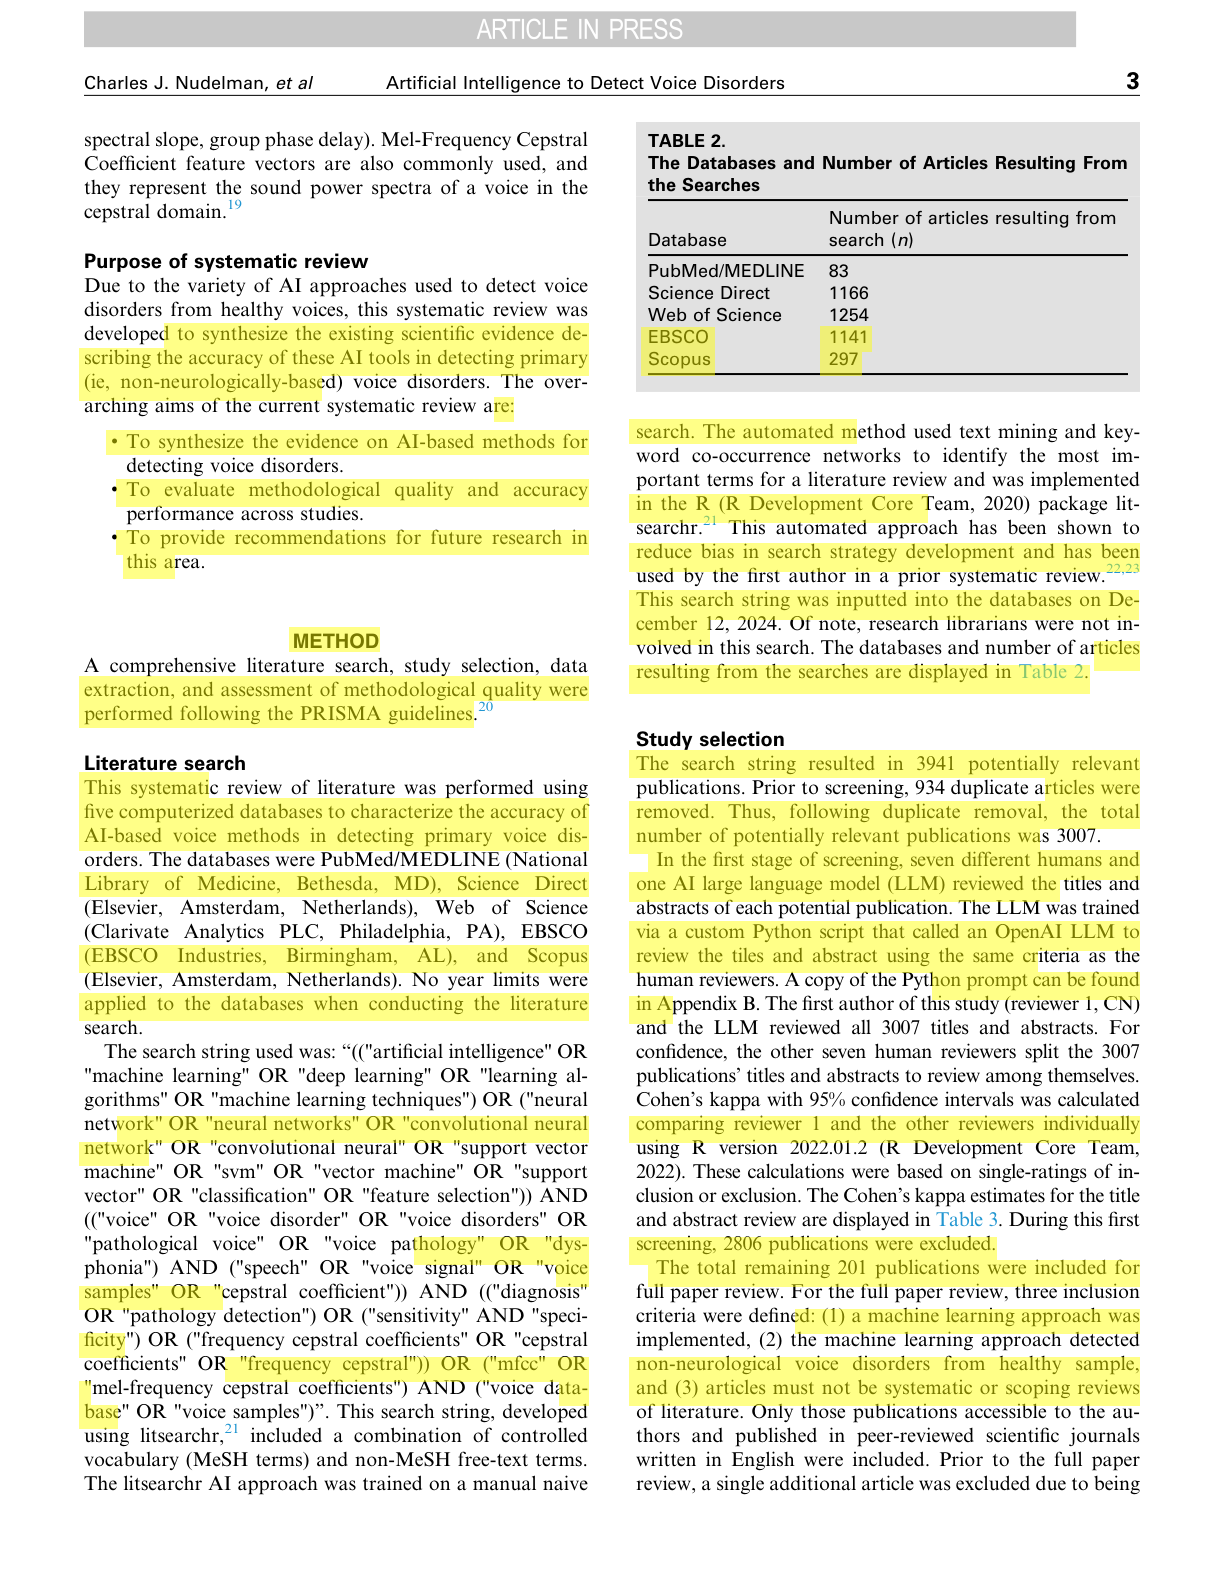

In [55]:
## Image part to generate the highlights
vis_image = image.convert("RGBA") # i dont know this, enables colors??
overlay = Image.new("RGBA", vis_image.size, (255, 255, 255, 0)) # creates new image of the same size?
draw_overlay = ImageDraw.Draw(overlay) ## this is a PIL.ImageDraw object


## Text
highlights = highlights_technical # -- or -- highlights_general
highlights = [item["text"] for item in highlights.get("highlights", [])]

print("Calculating Word-Level Precision...")

for phrase in highlights:
    
    # Use the new Multi-Line function
    # It returns a LIST of boxes (e.g., one for line 1, one for line 2)
    found_boxes = get_multiline_boxes(phrase, full_text, vis_image.size)
    
    if found_boxes:
        print(f"Found match for '{phrase}' (Spans {len(found_boxes)} lines)")
        
        # Iterate over every box segment found for this phrase
        for word_box in found_boxes:
            
            # --- YOUR PADDING SETTINGS (Unchanged) ---
            pad_x = 1  
            pad_y = 0  
            
            draw_overlay.rectangle(
                [
                    word_box[0] - pad_x,
                    word_box[1] - pad_y,
                    word_box[2] + pad_x,
                    word_box[3] + pad_y
                ], 
                fill=(255, 255, 0, 120),
                outline=None
            )
    else:
        print(f"Could not locate '{phrase}' in original text.")

final_image = Image.alpha_composite(vis_image, overlay).convert("RGB")
display(final_image)

In [56]:
# Final Save
final_image.save("highlighted page.jpg")
print("Done.")

Done.
